If ResNet stacks layers between residual connections, here we concatenate parallel transformations

In [3]:
!rm -r /content/Learning
!git clone https://github.com/valeman100/Learning.git
import sys
sys.path.append('/content/Learning/Fundamentals_For_Learning_Folder/') 
import Fundamentals_For_Learning as FFL
from torch import nn
from torch.nn import functional as F
import torch

Cloning into 'Learning'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 126 (delta 65), reused 94 (delta 39), pack-reused 0
Receiving objects: 100% (126/126), 1.32 MiB | 6.54 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [4]:
train_dl, val_dl, test_dl = FFL.data_preparation(batch=128, resize=(96, 96))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

60000 10000 375 94 79


c input channels are split into g groups via 1x1 convs then 3x3 convs are used to output b/g channels those channels are concatenated in b channels the c shape is restored with the last 1x1 conv

In [31]:
class ResNeXtBlock(nn.Module):
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
        super().__init__()
        # num_channels = c, bot_channels = b
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3, stride=strides,
                                   padding=1, groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()

        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)


class ResNeXt(FFL.Classifier):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            # self.add_module("conv1", Conv2d(3, 16, 5, padding=2))
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module("last", nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.LazyLinear(num_classes)))

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(ResNeXtBlock(num_channels, 16, 1, use_1x1conv=True, strides=2)) 
            else:
                blk.append(ResNeXtBlock(num_channels, 16, 1))
        return nn.Sequential(*blk)

class ResNeXt18(ResNeXt):
    def __init__(self, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), num_classes)


In [32]:
model, loss_f = FFL.get_model(ResNeXt18(), (1, 1, 96, 96))

X output shape:	 torch.Size([1, 1, 96, 96])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])

Number of parameters: 1697546


In [33]:
train_loss, val_loss, acc = FFL.fit(train_dl, val_dl, test_dl, loss_f, model, lr=0.01, epochs=10)

Epoch: 0, loss = 0.764831, v_loss = 0.457051, accuracy = 0.828422
Epoch: 1, loss = 0.405147, v_loss = 0.354852, accuracy = 0.852453
Epoch: 2, loss = 0.322913, v_loss = 0.301256, accuracy = 0.868275
Epoch: 3, loss = 0.261392, v_loss = 0.245071, accuracy = 0.876187
Epoch: 4, loss = 0.208646, v_loss = 0.206329, accuracy = 0.88212
Epoch: 5, loss = 0.161871, v_loss = 0.178347, accuracy = 0.882219
Epoch: 6, loss = 0.118621, v_loss = 0.145333, accuracy = 0.881626
Epoch: 7, loss = 0.079557, v_loss = 0.12254, accuracy = 0.882714
Epoch: 8, loss = 0.0489898, v_loss = 0.0991658, accuracy = 0.885285
Epoch: 9, loss = 0.0301101, v_loss = 0.0872748, accuracy = 0.887164


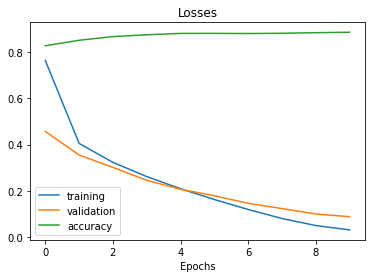

prediction comparison:

 tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
        False, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True, False, False,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  Tr

In [34]:
FFL.after_training_plots(train_loss, val_loss, acc)
X, y = next(iter(test_dl))
FFL.model_test(X, y, model)
FFL.torch.save(model.state_dict(), "/content/Learning/ResNeXt18_trained.pt")
#model.load_state_dict(FFL.torch.load("/content/Learning/ResNeXt18_trained.pt"))